In [1]:

import torch
import cv2
import numpy as np
import time
from fvcore.nn import FlopCountAnalysis

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VIDEO_PATH = "test.mov"
RESOLUTION = 384
WARMUP_FRAMES = 20
MEASURE_FRAMES = 200

In [16]:
model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
model.to(DEVICE)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
model_size_mb = total_params * 4 / (1024**2)  # FP32
print(f"Parameters: {total_params/1e6:.2f} M")
print(f"Model Size (FP32): {model_size_mb:.2f} MB")

dummy_input = torch.randn(1, 3, RESOLUTION, RESOLUTION).to(DEVICE)


Using cache found in /home/RUS_CIP/st189432/.cache/torch/hub/intel-isl_MiDaS_master
/home/RUS_CIP/st189432/MasterThesis/ddacs/Monocular-Depth-ViT-Optimization/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Parameters: 123.15 M
Model Size (FP32): 469.77 MB


In [30]:
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA, # Only include if CUDA is available
    ],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/transformer'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    for i in range(10):
        with torch.no_grad():
            model(dummy_input)
        prof.step()
print("Profiler run complete. Printing summary...")
print("-" * 50)
print(prof.key_averages().table(sort_by="flops", row_limit=20))

Profiler run complete. Printing summary...
--------------------------------------------------
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Memset (Device)         0.00%       0.000us         0.00%       0.000us       0.000us     223.675us   

Self CPU - Time spent inside that operator only, on the CPU.  
CPU total - Time spent in that operator including child calls.

In [34]:
with torch.profiler.profile( activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], with_flops=True ) as prof: 
    model(dummy_input) 
print(prof.key_averages().table(sort_by="flops", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.40%     216.903us         7.24%       3.919ms      48.389us       0.000us         0.00%      11.921ms     147.167us            81    142223.081  
                                            aten::addmm         2.00%       1.081ms         2.94%       1.590ms      31.798us      12.527ms        40.6

In [37]:
events = prof.key_averages()[0]
print(dir(events))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add', 'count', 'cpu_children', 'cpu_memory_usage', 'cpu_parent', 'cpu_time', 'cpu_time_str', 'cpu_time_total', 'cpu_time_total_str', 'cuda_time', 'device_memory_usage', 'device_time', 'device_time_str', 'device_time_total', 'device_time_total_str', 'device_type', 'flops', 'input_shapes', 'is_async', 'is_legacy', 'is_remote', 'is_user_annotation', 'key', 'node_id', 'overload_name', 'scope', 'self_cpu_memory_usage', 'self_cpu_time_total', 'self_cpu_time_total_str', 'self_device_memory_usage', 'self_device_time_total', 'self_device_time_total_str', 'stack', 'use_device']


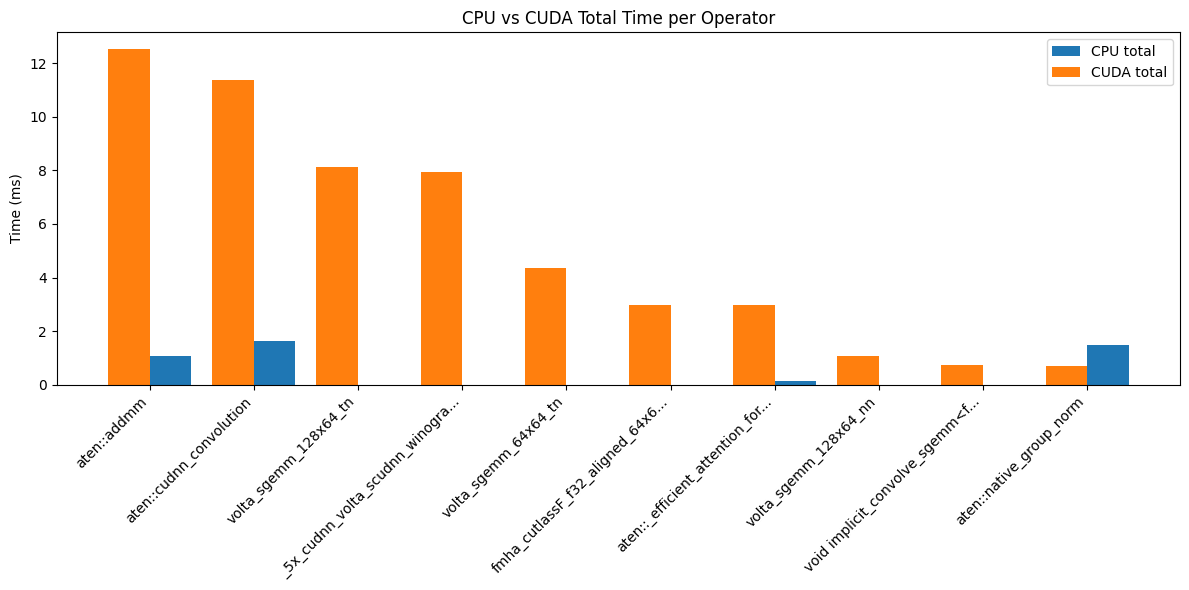

In [45]:
events = prof.key_averages()
# print(dir(events))

import pandas as pd

rows = []
for e in events:
    rows.append({
        "name": e.key,
        "cpu_total_ms": e.self_cpu_time_total / 1000.0,
        "cuda_total_ms": e.self_device_time_total / 1000.0,
        "calls": e.count
    })

df = pd.DataFrame(rows)
df = df[df["cuda_total_ms"] >0]

df = df.sort_values("cuda_total_ms", ascending=False)

import matplotlib.pyplot as plt

top_n = 10
df_top = df.head(top_n)

plt.figure(figsize=(12,6))
x = range(len(df_top))

plt.bar(x, df_top["cpu_total_ms"], width=0.4, label="CPU total", align="edge")
plt.bar(x, df_top["cuda_total_ms"], width=-0.4, label="CUDA total", align="edge")
max_len = 30
labels = [name[:max_len] + "..." if len(name) > max_len else name
          for name in df_top["name"]]
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Time (ms)")
plt.title("CPU vs CUDA Total Time per Operator")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)

latencies = []

torch.cuda.reset_peak_memory_stats()

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (RESOLUTION, RESOLUTION))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame / 255.0
    frame = torch.from_numpy(frame).permute(2,0,1).float().unsqueeze(0).to(DEVICE)

    if DEVICE == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        output = model(frame)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    if frame_count >= WARMUP_FRAMES:
        latencies.append((end - start) * 1000)

    frame_count += 1
    if frame_count >= (WARMUP_FRAMES + MEASURE_FRAMES):
        break

cap.release()

latencies = np.array(latencies)
print(f"Mean Latency: {latencies.mean():.2f} ms")
print(f"P50 Latency: {np.percentile(latencies,50):.2f} ms")
print(f"P95 Latency: {np.percentile(latencies,95):.2f} ms")
print(f"FPS: {1000.0/latencies.mean():.2f}")

if DEVICE == "cuda":
    peak_mem = torch.cuda.max_memory_allocated() / (1024**2)
    print(f"Peak GPU Memory: {peak_mem:.2f} MB")

Mean Latency: 37.26 ms
P50 Latency: 37.02 ms
P95 Latency: 39.25 ms
FPS: 26.84
Peak GPU Memory: 1860.74 MB


In [ ]:
OUTPUT_PATH = "depth_output.mp4" 
cap = cv2.VideoCapture(VIDEO_PATH)
orig_fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(
    OUTPUT_PATH,
    fourcc,
    orig_fps,
    (RESOLUTION, RESOLUTION)
)

print("Starting inference...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_resized = cv2.resize(frame, (RESOLUTION, RESOLUTION))
    rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    rgb = rgb / 255.0

    input_tensor = torch.from_numpy(rgb).permute(2,0,1).float().unsqueeze(0).to(DEVICE)

    if DEVICE == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        depth = model(input_tensor)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    latency_ms = (end - start) * 1000
    fps = 1000.0 / latency_ms

    depth = depth.squeeze().cpu().numpy()
    depth_min = depth.min()
    depth_max = depth.max()
    depth_vis = (depth - depth_min) / (depth_max - depth_min + 1e-8)
    depth_vis = (depth_vis * 255).astype(np.uint8)

    depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_INFERNO)

    # Overlay FPS
    cv2.putText(
        depth_color,
        f"FPS: {fps:.2f}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2
    )

    writer.write(depth_color)

cap.release()
writer.release()

print("Saved:", OUTPUT_PATH)

Starting inference...
Saved: depth_output.mp4
